In [50]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential, Model
import random
import sklearn
from tensorflow.keras.regularizers import L1L2

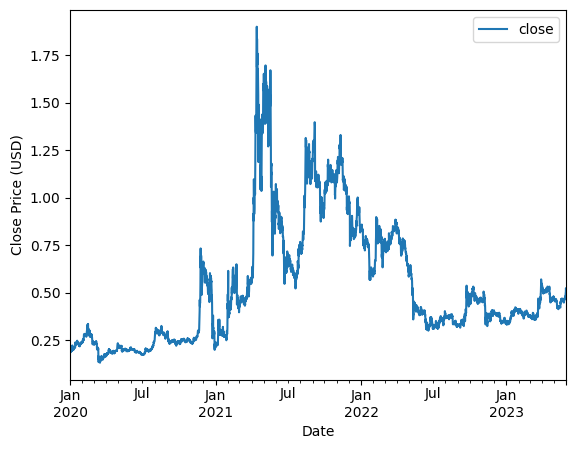

In [51]:
# Read the data from a CSV file
url = "/home/yass/code/yass2803/cryptoteller/data/XRPUSDT.csv"
df = pd.read_csv(url)
df.head()

# Change the time unit of the "open_time" column
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

df.shape

# Plot the closing price over time
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

plt.show()

In [52]:
# Normalization
scaler = StandardScaler()
close_price = df.close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

False

In [53]:
def date_to_string(date_):
    year = str(date_.year)
    month = str(date_.month)
    day = str(date_.day)

    if len(day) == 1:
        day = "0" + day

    if len(month) == 1:
        month = "0" + month

    return year + "-" + month + "-" + day

In [54]:
df_sentiment = pd.read_csv("/home/yass/code/yass2803/cryptoteller/data/sentiment/aggr_sent_eth.csv")

df_dates = df[["open_time"]].copy()
df_dates.loc[:,"date"] = df_dates.open_time.apply(lambda x: date_to_string(x))

df_sentiment = df_dates.merge(df_sentiment, on="date", how="left")
df_sentiment.drop(columns="date", inplace=True)
df_sentiment.head()


not_nan_idx = np.where(~np.isnan(df_sentiment.sentiment.values))[0]

sentiment = df_sentiment.iloc[not_nan_idx,:].sentiment.values.reshape(-1, 1)

scaled_returns_red = scaled_close[not_nan_idx]

#OHE_encoder=sklearn.preprocessing.OneHotEncoder(categories=[[0,1,2]])
#OHE_sentiment=OHE_encoder.fit_transform(sentiment).toarray()

#n_sentiment_classes = len(OHE_encoder.categories_[0])

In [55]:
class Preprocessor:
    def __init__(self, SEQ_LEN=70):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data,sentiment, seq_len):
        d = []
        s=[]

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])
            s.append(sentiment[index:index+seq_len])

        return np.array(d), np.array(s)

    def preprocess(self, data_raw,sentiment, train_split):

        data, sentiment = self.to_sequences(data_raw, sentiment, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]
        sentiment_train=sentiment[:self.num_train, :-1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]
        sentiment_test=sentiment[self.num_train:, :-1, :]

        return X_train, y_train, X_test, y_test, sentiment_train, sentiment_test

preprocessor=Preprocessor()
X_train, y_train, X_test, y_test, sentiment_train, sentiment_test = preprocessor.preprocess(scaled_returns_red,sentiment, train_split = 0.80)

print(f"sentiment train dtype: {sentiment_train.dtype}")

sentiment train dtype: float64


In [56]:
X_train=np.concatenate([X_train,sentiment_train],axis=2)

In [57]:
X_test=np.concatenate([X_test,sentiment_test],axis=2)

In [58]:
# Model

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1



def init_model(WINDOW_SIZE, n_sentiments, dropout, loss, optimizer, metrics):
    inputs_price = keras.Input(shape=(WINDOW_SIZE, 4))

    hidden_lstm = LSTM(10, return_sequences=True, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(inputs_price)
    hidden_lstm = Dropout(rate=dropout)(hidden_lstm)

    hidden_lstm = LSTM(20, return_sequences=True, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(hidden_lstm)
    hidden_lstm = Dropout(rate=dropout)(hidden_lstm)

    hidden_lstm = LSTM(30, return_sequences=False, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(hidden_lstm)

    hidden_final = keras.layers.Dense(32)(hidden_lstm)
    output = Dense(1, activation="linear")(hidden_final)
    model = Model(inputs=inputs_price, outputs=output)

    print(model.summary())
    return model


In [59]:


model_seq = keras.Sequential()

model_seq.add(LSTM(WINDOW_SIZE, return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[-1])),
                        )
model_seq.add(Dropout(rate=DROPOUT))

model_seq.add(LSTM(WINDOW_SIZE * 2, return_sequences=False))
model_seq.add(Dropout(rate=DROPOUT))

#model_seq.add(LSTM(WINDOW_SIZE, return_sequences=False))

model_seq.add(Dense(units=1))

model_seq.add(Activation('linear'))

In [60]:
#model=init_model(WINDOW_SIZE, n_sentiment_classes, DROPOUT, 'mean_squared_error', 'adam', ["mae"])
# Training
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

es = EarlyStopping(monitor="val_loss",
                       patience=25,
                       mode="min",
                       restore_best_weights=True)


model_seq.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer="adam"
)

BATCH_SIZE = 32

history = model_seq.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/40


71/71 [==============================] - 20s 197ms/step - loss: 0.2614 - mae: 0.3577 - val_loss: 0.3521 - val_mae: 0.5858
Epoch 2/40
71/71 [==============================] - 13s 177ms/step - loss: 0.2198 - mae: 0.3080 - val_loss: 0.0335 - val_mae: 0.1728
Epoch 3/40
71/71 [==============================] - 14s 196ms/step - loss: 0.1043 - mae: 0.2100 - val_loss: 0.0065 - val_mae: 0.0496
Epoch 4/40
71/71 [==============================] - 14s 198ms/step - loss: 0.0646 - mae: 0.1635 - val_loss: 0.0126 - val_mae: 0.0865
Epoch 5/40
71/71 [==============================] - 14s 202ms/step - loss: 0.0398 - mae: 0.1304 - val_loss: 0.0063 - val_mae: 0.0603
Epoch 6/40
71/71 [==============================] - 14s 202ms/step - loss: 0.0373 - mae: 0.1309 - val_loss: 0.0072 - val_mae: 0.0681
Epoch 7/40
71/71 [==============================] - 12s 175ms/step - loss: 0.0391 - mae: 0.1315 - val_loss: 0.0099 - val_mae: 0.0859
Epoch 8/40
71/71 [==============================] - 13s 179ms/step - loss: 0.043

20/20 [==============================] - 1s 61ms/step - loss: 0.0013 - mae: 0.0218
MAE for the test set: 0.5378113681737446


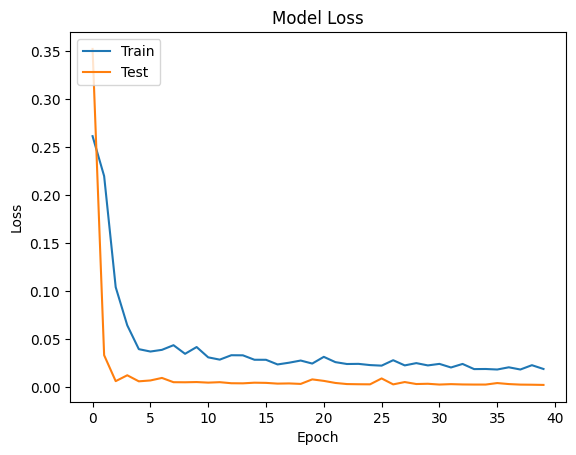

In [61]:
# Evaluation
MAE=scaler.inverse_transform([[model_seq.evaluate(X_test, y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [62]:
from sklearn.metrics import accuracy_score
# Prediction
y_hat = model_seq.predict(X_test)
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
y_train_inverse=scaler.inverse_transform(y_train)



20/20 [==============================] - 2s 61ms/step


In [63]:
'''# Plot the actual and predicted prices
# Prediction
date_time_test = df.iloc[not_nan_idx,:].iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.show()'''

'# Plot the actual and predicted prices\n# Prediction\ndate_time_test = df.iloc[not_nan_idx,:].iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()\n\n# Plot the actual and predicted prices\nplt.figure(figsize=(12, 8))  # Set the figure size to make it larger\nplt.plot(date_time_test, y_test_inverse, label="Actual Price", color=\'green\')\nplt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color=\'red\')\n\n# Customize the plot\nplt.title(\'Bitcoin Price Prediction\')\nplt.xlabel(\'Time [days]\')\nplt.ylabel(\'Price\')\nplt.show()'

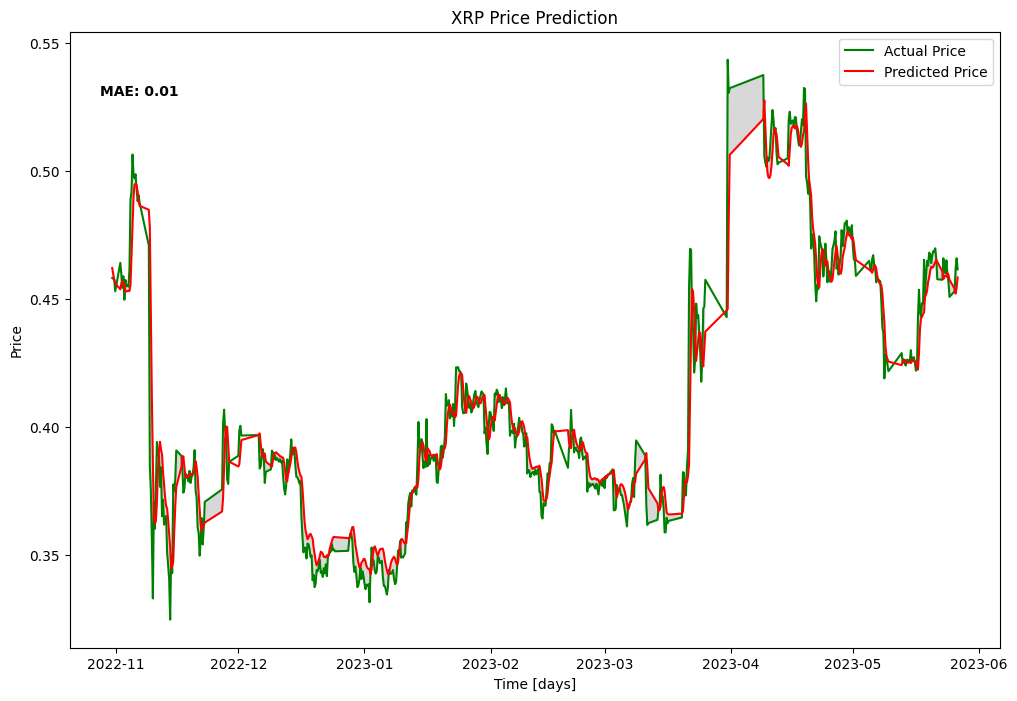

In [64]:
import matplotlib.pyplot as plt
import numpy as np
date_time_test = df.iloc[not_nan_idx,:].iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()
# Plot the actual and predicted prices

# Convertir y_hat_inverse y y_test_inverse a arrays unidimensionales
y_hat_inverse = np.squeeze(y_hat_inverse)
y_test_inverse = np.squeeze(y_test_inverse)

# Calcular MAE
mae = np.mean(np.abs(y_test_inverse - y_hat_inverse))

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Add shadow to the predicted price line
import matplotlib.pyplot as plt

plt.fill_between(date_time_test, y_hat_inverse, y_test_inverse, where=(y_hat_inverse > y_test_inverse), facecolor='gray', alpha=0.3)
plt.fill_between(date_time_test, y_hat_inverse, y_test_inverse, where=(y_hat_inverse < y_test_inverse), facecolor='gray', alpha=0.3)


# Add legend and MAE information
plt.legend()
plt.title('XRP Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.figtext(0.15, 0.8, f'MAE: {mae:.2f}', color='black', weight='bold')

# Display the plot
plt.show()



In [65]:


model_seq.accuracy

AttributeError: 'Sequential' object has no attribute 'accuracy'